# Дизайн эксперимента

### Цель эксперимента
Цель данного эксперимента — протестировать гипотезу, что изменение расположения рекламного блока в приложении влияет на взаимодействие пользователей с этим блоком. Мы будем проверять, увеличится ли кликабельность и конверсия в добавление товаров в корзину и заказы, если рекламный блок будет перемещен выше на главной странице.

### Гипотеза
Мы предполагаем, что перемещение первого рекламного блока выше в ленте товаров положительно скажется на взаимодействии пользователей, увеличив основные метрики, такие как кликабельность (CTR) и конверсия в добавление товаров в корзину и заказы (CR).

**Метрики для отслеживания**  
Для оценки успешности эксперимента мы определили следующие ключевую и вспомогательные метрики:

1. **Ключевая метрика (CTR):**  
   - Кликабельность рекламного блока (CTR) рассчитывается как отношение количества кликов на рекламу к количеству просмотров главного экрана.
   - Формула: **CTR = clicks / views**

2. **Вспомогательные метрики:**  
   - **CR (конверсия в добавление):** Конверсия добавления товаров в корзину из рекламного блока. Определяется как отношение количества добавлений к количеству кликов на рекламный блок.  
     - Формула: **CR = adds / clicks**
   - **Конверсия в заказ:** Конверсия заказов от взаимодействия с рекламой, то есть доля пользователей, сделавших заказ после клика на рекламный блок.
   - **Выручка на пользователя (ARPU):** Средняя выручка на пользователя по товарам, добавленным из рекламного блока.
   - **Выручка на покупателя (ARPPU):** Средняя выручка на покупателя по товарам, добавленным из рекламного блока.

**Критерий успеха эксперимента**  
Эксперимент будет считаться успешным, если ключевая метрика CTR (кликабельность) и другие вспомогательные метрики, такие как CR, значительно увеличатся в тестовой группе по сравнению с контрольной.


In [1]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd

# Загрузка данных из файла data_raw.csv
file_path = '/content/drive/MyDrive/Zerocode projects/DataAnalysis/Final_project/data_raw.csv'  #  актуальный путь к файлу
data = pd.read_csv(file_path)

# Проверка первых строк данных для изучения структуры
data.head()


,Unnamed: 0,client_id,dt,event_type
0,0,6095092,2024-06-20,clicks
1,1,541138559,2024-06-18,clicks
2,2,12189072,2024-06-20,clicks
3,3,674385020,2024-06-20,clicks
4,4,726939378,2024-06-20,clicks


### Изучение данных
Наши данные содержат информацию о действиях пользователей в приложении, которые можно разделить на три типа:

views — просмотр главного экрана магазина, что свидетельствует о входе пользователя в приложение.
clicks — клик на рекламный блок, который открывает подборку товаров.
adds — добавление товаров из рекламного блока в корзину.
Для каждой записи указаны:

client_id — идентификатор пользователя.
dt — дата события.
event_type — тип действия (view, click, add).
На этом этапе мы исследуем данные, чтобы понять распределение действий пользователей и частоту различных типов событий. Это поможет лучше понять, как пользователи взаимодействуют с рекламным блоком на текущих позициях.

In [3]:
# Проверка информации о данных и типов событий
data.info()

# Подсчет количества событий каждого типа
event_counts = data['event_type'].value_counts()
print("Количество событий каждого типа:")
print(event_counts)

# Подсчет количества уникальных пользователей
unique_users = data['client_id'].nunique()
print(f"\nОбщее количество уникальных пользователей: {unique_users}")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27756048 entries, 0 to 27756047
Data columns (total 4 columns):
 #   Column      Dtype 
---  ------      ----- 
 0   Unnamed: 0  int64 
 1   client_id   int64 
 2   dt          object
 3   event_type  object
dtypes: int64(2), object(2)
memory usage: 847.0+ MB
Количество событий каждого типа:
event_type
views     27006473
clicks      535927
adds        213648
Name: count, dtype: int64

Общее количество уникальных пользователей: 3102736


### Приведение данных к формату воронки
Для того чтобы получить представление о том, как пользователи переходят по воронке от просмотра главного экрана до добавления товаров в корзину, мы создадим агрегированную таблицу. Эта таблица будет содержать для каждого пользователя и даты информацию о наличии событий каждого типа: был ли просмотр главной страницы, клик по рекламе или добавление товара.

Каждому типу события на определенную дату будем присваивать 1, если событие происходило, и 0, если нет.

In [4]:
# Преобразуем данные в формат даты с корректным форматом
data['dt'] = pd.to_datetime(data['dt'], format='%Y-%m-%d')

# Присваиваем 1, если событие происходило хотя бы один раз в день для каждого пользователя
funnel_data_binary = data.groupby(['client_id', 'dt', 'event_type']).size().unstack(fill_value=0).reset_index()

# Заменяем все положительные значения на 1 для преобразования в формат бинарных значений
funnel_data_binary['clicks'] = (funnel_data_binary['clicks'] > 0).astype(int)
funnel_data_binary['views'] = (funnel_data_binary['views'] > 0).astype(int)
funnel_data_binary['adds'] = (funnel_data_binary['adds'] > 0).astype(int)

# Просмотрим первые строки для проверки
funnel_data_binary.head(20)



event_type,client_id,dt,adds,clicks,views
0,1,2024-06-17,0,0,1
1,1,2024-06-19,0,0,1
2,3,2024-06-17,0,1,1
3,3,2024-06-18,0,1,1
4,3,2024-06-19,1,1,1
5,3,2024-06-20,0,0,1
6,4,2024-06-18,0,0,1
7,4,2024-06-19,0,0,1
8,4,2024-06-20,0,0,1
9,4,2024-06-21,0,0,1


**Расчёт ключевых метрик**  
Теперь, когда у нас есть таблица с данными о факте наличия событий (view, click, add) по каждому пользователю на каждую дату, мы можем рассчитать ключевые метрики, такие как CTR (конверсия в просмотр) и CR (конверсия в добавление), чтобы оценить поведение пользователей.

- **CTR (конверсия в просмотр):** отношение количества дней, когда пользователь кликал на рекламу, к количеству дней, когда он просматривал главную страницу.
- **CR (конверсия в добавление):** отношение количества дней, когда пользователь добавлял товар, к количеству дней, когда он кликал на рекламу.


In [14]:
# Агрегация данных по пользователю за весь период, исключая столбец с датой
user_aggregated = funnel_data_binary.drop(columns=['dt']).groupby('client_id').sum().reset_index()

# Рассчитываем CTR и CR на уровне пользователя
user_aggregated['CTR'] = user_aggregated['clicks'] / user_aggregated['views']
user_aggregated['CR'] = user_aggregated['adds'] / user_aggregated['clicks']




In [15]:
user_aggregated.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3102736 entries, 0 to 3102735
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   client_id  int64  
 1   adds       int64  
 2   clicks     int64  
 3   views      int64  
 4   CTR        float64
 5   CR         float64
dtypes: float64(2), int64(4)
memory usage: 142.0 MB


In [18]:
user_aggregated.head()

event_type,client_id,adds,clicks,views,CTR,CR
0,1,0,0,2,0.00,NaN
1,3,1,3,4,0.75,0.333333
2,4,0,0,4,0.00,NaN
3,19,0,0,4,0.00,NaN
4,27,0,0,2,0.00,NaN


In [22]:
# Заменим NaN на 0 для корректности расчётов
user_aggregated['CTR'] = user_aggregated['CTR'].fillna(0)
user_aggregated['CR'] = user_aggregated['CR'].fillna(0)

# Отфильтруем данные для расчёта средних значений и дисперсий
filtered_ctr = user_aggregated[user_aggregated['views'] > 0]
filtered_cr = user_aggregated[user_aggregated['clicks'] > 0]

# Расчёт среднего для CTR и CR
mean_ctr = filtered_ctr['CTR'].mean()
mean_cr = filtered_cr['CR'].mean()

In [23]:
import numpy as np
# Функция для расчета дисперсии ratio-метрики с использованием дельта-метода
def var_ratio(x, y):
    mean_x = np.mean(x)
    mean_y = np.mean(y)
    var_x = np.var(x, ddof=1)
    var_y = np.var(y, ddof=1)
    cov_xy = np.cov(x, y, ddof=1)[0][1]
    result = var_x / mean_y**2 + var_y * mean_x**2 / mean_y**4 - 2 * mean_x * cov_xy / mean_y**3
    return result

# Расчет дисперсии для CTR и CR с использованием дельта-метода
var_ctr = var_ratio(filtered_ctr['clicks'], filtered_ctr['views'])
std_ctr = np.sqrt(var_ctr)

var_cr = var_ratio(filtered_cr['adds'], filtered_cr['clicks'])
std_cr = np.sqrt(var_cr)

print(f"Среднее CTR: {mean_ctr:.4f}, Стандартное отклонение CTR (дельта-метод): {std_ctr:.4f}")
print(f"Среднее CR: {mean_cr:.4f}, Стандартное отклонение CR (дельта-метод): {std_cr:.4f}")


Среднее CTR: 0.0338, Стандартное отклонение CTR (дельта-метод): 0.1754
Среднее CR: 0.4443, Стандартное отклонение CR (дельта-метод): 0.5785


**Расчёт MDE и определение размера выборки**  
Теперь, когда у нас есть рассчитанные метрики, мы можем переходить к оценке минимального наблюдаемого эффекта (MDE) и определению необходимого размера выборки для проведения A/B-теста. Мы будем использовать исторические данные для расчёта среднего значения и стандартного отклонения ключевых метрик.

**MDE (минимальный наблюдаемый эффект)** — это минимальная величина эффекта, которую тест должен быть способен обнаружить с заданной статистической мощностью и уровнем значимости.



In [24]:
# Определяем период времени, за который есть данные
start_date = data['dt'].min()
end_date = data['dt'].max()

print(f"Данные охватывают период с {start_date.date()} по {end_date.date()}")

# Определяем количество уникальных пользователей за одну неделю
unique_users_per_week = data[data['dt'].between(start_date, start_date + pd.Timedelta(weeks=1))]['client_id'].nunique()

# Рассчитываем 20% от общего количества уникальных пользователей
sample_size = int(unique_users_per_week * 0.2)

print(f"Общее количество уникальных пользователей за неделю: {unique_users_per_week}")
print(f"Размер выборки (20% от пользователей): {sample_size}")

Данные охватывают период с 2024-06-17 по 2024-06-21
Общее количество уникальных пользователей за неделю: 3102736
Размер выборки (20% от пользователей): 620547


In [28]:
from scipy import stats
import numpy as np
from scipy import stats

# Функция для расчета MDE
def get_MDE(mu, std, sample_size, n_groups=2, target_share=0.5, r=1, alpha=0.05, beta=0.2):
    """
    Возвращает MDE для пользовательской метрики при заданных параметрах теста.

    mu: float, среднее выборки на исторических данных.
    std: float, стандартное отклонение выборки на исторических данных.
    sample_size: int, размер выборки для теста (включает все группы).
    n_groups: int, количество групп в тесте (по умолчанию 2).
    target_share: float, доля одной целевой группы (по умолчанию 0.5 для равных групп).
    r: float, отношение самой маленькой группы к самой большой группе (по умолчанию 1).
    alpha: float, уровень ошибки I рода (по умолчанию 0.05).
    beta: float, уровень ошибки II рода (по умолчанию 0.2).

    return: mde, mde_percent - абсолютное значение MDE и MDE в процентах.
    """
    t_alpha = stats.norm.ppf(1 - (alpha / 2))
    t_beta = stats.norm.ppf(1 - beta)
    sample_ratio_correction = r + 2 + 1 / r
    mde = np.sqrt(sample_ratio_correction) * (t_alpha + t_beta) * std / np.sqrt(sample_size * (1 - target_share * (n_groups - 1)))
    return mde, mde * 100 / mu

# Расчет MDE для CTR
mde_ctr, mde_ctr_percent = get_MDE(mean_ctr, std_ctr, sample_size)
print(f"MDE для CTR: {mde_ctr:.4f}, что составляет {mde_ctr_percent:.2f}% от среднего CTR")

# Расчет MDE для CR
mde_cr, mde_cr_percent = get_MDE(mean_cr, std_cr, sample_size)
print(f"MDE для CR: {mde_cr:.4f}, что составляет {mde_cr_percent:.2f}% от среднего CR")


MDE для CTR: 0.0018, что составляет 5.23% от среднего CTR
MDE для CR: 0.0058, что составляет 1.31% от среднего CR


In [29]:
# Определяем диапазон размеров выборок (от 10% до 20% от общего количества уникальных пользователей)
percentages = np.arange(0.1, 0.21, 0.01)
sample_sizes = [int(unique_users_per_week * p) for p in percentages]

# Создаем таблицу значений MDE и размеров выборки
mde_table = []

for sample_size in sample_sizes:
    mde_ctr, mde_ctr_percent = get_MDE(mean_ctr, std_ctr, sample_size)
    mde_cr, mde_cr_percent = get_MDE(mean_cr, std_cr, sample_size)
    mde_table.append({
        'Размер выборки': sample_size,
        'MDE для CTR (абс.)': round(mde_ctr, 4),
        'MDE для CTR (%)': round(mde_ctr_percent, 2),
        'MDE для CR (абс.)': round(mde_cr, 4),
        'MDE для CR (%)': round(mde_cr_percent, 2)
    })

# Преобразуем список словарей в DataFrame и выводим его
mde_df = pd.DataFrame(mde_table)

# Вывод таблицы с помощью display
from IPython.display import display
display(mde_df)


,Размер выборки,MDE для CTR (абс.),MDE для CTR (%),MDE для CR (абс.),MDE для CR (%)
0,310273,0.0025,7.39,0.0082,1.85
1,341300,0.0024,7.05,0.0078,1.77
2,372328,0.0023,6.75,0.0075,1.69
3,403355,0.0022,6.48,0.0072,1.62
4,434383,0.0021,6.25,0.0070,1.57
5,465410,0.0020,6.03,0.0067,1.51
6,496437,0.0020,5.84,0.0065,1.46
7,527465,0.0019,5.67,0.0063,1.42
8,558492,0.0019,5.51,0.0061,1.38
9,589519,0.0018,5.36,0.0060,1.34


Для выбора основной метрики для A/B теста необходимо учитывать, что целью эксперимента является оценка влияния изменения расположения рекламы на взаимодействие пользователей. Мы должны выбрать метрику, которая наиболее точно отражает эту цель, и оценить, является ли увеличение на **2,5%** (взято из ограничений, полученых на прошлых тестах) в пределах наблюдаемого MDE.

### Анализ таблицы MDE и условий:
1. **MDE для CTR**:
   - Абсолютные значения MDE для CTR варьируются от **0.0025** до **0.0018**.
   - В процентном отношении MDE для CTR составляет от **7.39%** до **5.23%**.
   - Целевое увеличение на **2,5%** меньше минимального MDE для CTR, что означает, что мы, вероятно, не сможем зафиксировать такие изменения для этой метрики в текущем тесте.

2. **MDE для CR**:
   - Абсолютные значения MDE для CR варьируются от **0.0082** до **0.0058**.
   - В процентном отношении MDE для CR составляет от **1.85%** до **1.31%**.
   - Целевое увеличение на **2,5%** находится в пределах наблюдаемого MDE для CR, что означает, что у нас есть шанс зафиксировать значимые изменения этой метрики в текущем тесте.

### Вывод:
**Основная метрика для A/B теста** — **конверсия в добавление товаров в корзину (CR)**.

### Обоснование:
- **MDE для CR** позволяет фиксировать изменения на уровне **2,5%**, что соответствует ожидаемому эффекту от эксперимента.
- **CR** более чувствительна к изменениям в пользовательском поведении, связанном с добавлением товаров в корзину, и отражает взаимодействие пользователей с рекламой.

Таким образом, мы будем использовать **CR** в качестве основной метрики для нашего A/B теста.

Мы можем ожидать "прокраски" теста даже на 10% выборке (310 тыс пользователей) за неделю, но возьмем максимально доступный объем данных для анализа, так как это сделает наши выводы более уверенными и даст возможность лучшего анализа вспомогательных метрик.

# Не смотря на поставленное задание, мы не можем изучить пользовательское поведение до эксперимента

Датадмин, с;%а, не включил необходимые источники в data_raw.csv

# Подождем неделю...
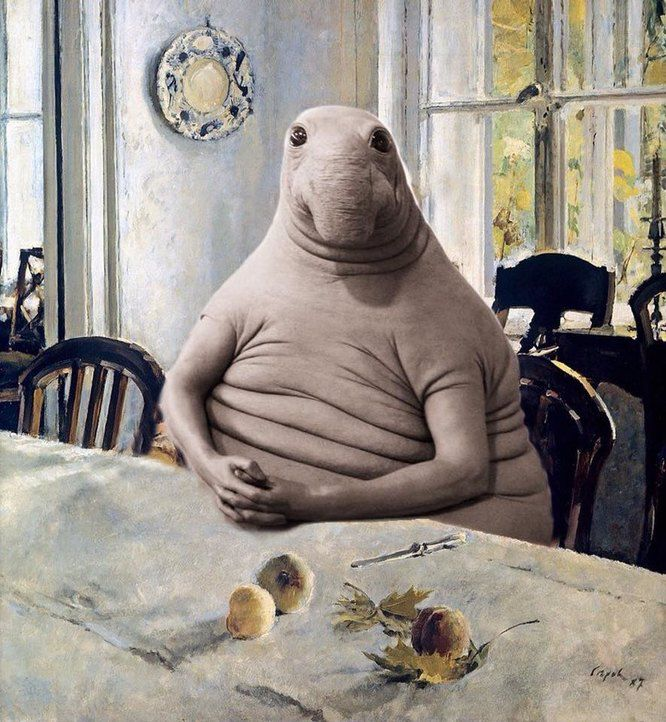

# ***Результаты***

In [30]:
# Путь к файлу
file_path = '/content/drive/MyDrive/Zerocode projects/DataAnalysis/Final_project/final_results_to_analyze.xlsx'

# Загрузка данных из Excel
data_results = pd.read_excel(file_path)



,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,2024-07-26,8881380,test,0,0,0,0,0,0,0,0
1,2024-07-28,850950385,test,0,0,0,0,0,0,0,0
2,2024-07-25,50885,control,0,0,0,0,0,0,0,0
3,2024-07-26,601239,control,0,0,0,0,0,0,0,0
4,2024-07-28,694655866,control,0,0,0,0,0,0,0,0


In [37]:
# Просмотр первых строк данных для проверки
data_results.head()

,date,client_id,ab_group,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
0,2024-07-26,8881380,test,0,0,0,0,0,0,0,0
1,2024-07-28,850950385,test,0,0,0,0,0,0,0,0
2,2024-07-25,50885,control,0,0,0,0,0,0,0,0
3,2024-07-26,601239,control,0,0,0,0,0,0,0,0
4,2024-07-28,694655866,control,0,0,0,0,0,0,0,0


In [34]:
data_results.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 981510 entries, 0 to 981509
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   date            981510 non-null  datetime64[ns]
 1   client_id       981510 non-null  int64         
 2   ab_group        981510 non-null  object        
 3   is_view_ads     981510 non-null  int64         
 4   cnt_view_ads    981510 non-null  int64         
 5   is_adds_ads     981510 non-null  int64         
 6   cnt_adds_ads    981510 non-null  int64         
 7   sum_adds_ads    981510 non-null  int64         
 8   is_orders_ads   981510 non-null  int64         
 9   cnt_orders_ads  981510 non-null  int64         
 10  sum_orders_ads  981510 non-null  int64         
dtypes: datetime64[ns](1), int64(9), object(1)
memory usage: 82.4+ MB


In [35]:
data_results.describe()

,date,client_id,is_view_ads,cnt_view_ads,is_adds_ads,cnt_adds_ads,sum_adds_ads,is_orders_ads,cnt_orders_ads,sum_orders_ads
count,981510,9.815100e+05,981510.000000,981510.000000,981510.000000,981510.000000,981510.000000,981510.000000,981510.000000,981510.000000
mean,2024-07-27 00:18:44.024818944,1.708445e+08,0.052206,0.088918,0.014411,0.032741,5.082794,0.012481,0.011676,3.339542
min,2024-07-24 00:00:00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2024-07-25 00:00:00,1.143451e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2024-07-27 00:00:00,9.681953e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2024-07-29 00:00:00,8.993345e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,2024-07-30 00:00:00,9.688485e+08,1.000000,28.000000,1.000000,26.000000,5809.000000,1.000000,5.000000,5809.000000
std,NaN,3.023737e+08,0.222443,0.475500,0.119180,0.350391,57.082421,0.111018,0.138554,45.843918


## Проведение предварительного анализа данных
Для начала важно рассмотреть следующие шаги:
1. **Проверка распределения пользователей по группам (контрольная и тестовая)**.
2. **Анализ основных метрик** для каждой группы, таких как:
   - Среднее количество просмотров рекламы.
   - Среднее количество добавлений и сумма добавлений.
   - Количество и сумма заказов.

***Замечание:*** на основе предоставленных данных мы не можем судить о географической, демографической и прочих однородностях наших групп. **Будем предполагать, что контрольная и тестовая группы выбраны правильно и однородны, а единственным фактором отличая является положение рекламного банера.**


In [38]:
# Проверка распределения пользователей по группам
group_counts = data_results['ab_group'].value_counts()

print("Распределение пользователей по группам:")
print(group_counts)

# Рассчитаем основные метрики для каждой группы
group_metrics = data_results.groupby('ab_group').agg({
    'cnt_view_ads': 'mean',
    'cnt_adds_ads': 'mean',
    'sum_adds_ads': 'mean',
    'cnt_orders_ads': 'mean',
    'sum_orders_ads': 'mean'
}).reset_index()

# Переименуем колонки для удобства
group_metrics.columns = [
    'AB Group',
    'Avg Views of Ads',
    'Avg Adds from Ads',
    'Avg Sum of Adds from Ads',
    'Avg Orders from Ads',
    'Avg Sum of Orders from Ads'
]

# Отобразим таблицу метрик для групп
from IPython.display import display
display(group_metrics)


Распределение пользователей по группам:
ab_group
test       491652
control    489858
Name: count, dtype: int64


,AB Group,Avg Views of Ads,Avg Adds from Ads,Avg Sum of Adds from Ads,Avg Orders from Ads,Avg Sum of Orders from Ads
0,control,0.088738,0.032252,5.026804,0.011389,3.245632
1,test,0.089098,0.033229,5.138580,0.011962,3.433109


### Анализ распределения и основных метрик:
1. **Распределение пользователей по группам**:
   - Количество пользователей в тестовой группе: **491,652**.
   - Количество пользователей в контрольной группе: **489,858**.
   - Обе группы почти равны по размеру, что хорошо для сравнения результатов и уменьшения смещения.

2. **Основные метрики**:
   - **Среднее количество просмотров рекламы**: примерно одинаково для обеих групп (0.0887 в контрольной и 0.0891 в тестовой).
   - **Среднее количество добавлений из рекламы**: немного выше в тестовой группе (0.0332) по сравнению с контрольной (0.0323).
   - **Средняя сумма добавлений из рекламы**: также выше в тестовой группе (5.1386) против контрольной (5.0268).
   - **Среднее количество заказов из рекламы**: немного выше в тестовой группе (0.0120) по сравнению с контрольной (0.0114).
   - **Средняя сумма заказов из рекламы**: выше в тестовой группе (3.4331) против контрольной (3.2456).

### Предварительные выводы:
- **Тестовая группа** показывает небольшое улучшение по всем основным метрикам, что может свидетельствовать о положительном влиянии изменения расположения рекламы.
- **Разница в метриках** между тестовой и контрольной группами требует статистического анализа, чтобы определить, являются ли эти различия значимыми.

### Следующий шаг:
Проведем **статистический анализ** (например, t-тест) для сравнения средних значений основных метрик между тестовой и контрольной группами, чтобы определить, являются ли различия значимыми.

### План анализа:
1. Провести t-тест для различных метрик: мы будем использовать t-тест для сравнения средних значений ключевой метрики (конверсия в добавление товаров в корзину — CR) и дополнительных метрик между тестовой и контрольной группами.
2. Оценить статистическую значимость результатов.


In [39]:
from scipy import stats

# Разделяем данные на контрольную и тестовую группы
control_group = data_results[data_results['ab_group'] == 'control']
test_group = data_results[data_results['ab_group'] == 'test']

# Определение метрик для теста (CR - среднее количество добавлений)
metrics = ['cnt_adds_ads', 'sum_adds_ads', 'cnt_orders_ads', 'sum_orders_ads']

# Функция для проведения t-теста и вывода результатов
def run_t_test(control, test, metric):
    t_stat, p_value = stats.ttest_ind(control[metric], test[metric], equal_var=False)
    print(f"Метрика: {metric}")
    print(f"T-statistic: {t_stat:.4f}, p-value: {p_value:.4f}")
    if p_value < 0.05:
        print("Результат статистически значим (p < 0.05).")
    else:
        print("Результат НЕ статистически значим (p >= 0.05).")
    print("-" * 50)

# Проведение t-теста для каждой метрики
for metric in metrics:
    run_t_test(control_group, test_group, metric)


Метрика: cnt_adds_ads
T-statistic: -1.3807, p-value: 0.1674
Результат НЕ статистически значим (p >= 0.05).
--------------------------------------------------
Метрика: sum_adds_ads
T-statistic: -0.9700, p-value: 0.3320
Результат НЕ статистически значим (p >= 0.05).
--------------------------------------------------
Метрика: cnt_orders_ads
T-statistic: -2.0477, p-value: 0.0406
Результат статистически значим (p < 0.05).
--------------------------------------------------
Метрика: sum_orders_ads
T-statistic: -2.0259, p-value: 0.0428
Результат статистически значим (p < 0.05).
--------------------------------------------------


Результаты t-тестов показали следующую статистическую значимость для вспомогательных метрик:

### Интерпретация результатов:
1. **Количество добавлений товаров из рекламы (cnt_adds_ads)**:
   - **T-statistic: -1.3807, p-value: 0.1674**
   - Результат не является статистически значимым (p >= 0.05), что указывает на то, что изменения в тестовой группе не привели к значимому изменению количества добавлений товаров. Это значит, что пользователи тестовой группы не проявили значимых различий в поведении относительно добавлений товаров по сравнению с контрольной группой.

2. **Сумма добавлений товаров из рекламы (sum_adds_ads)**:
   - **T-statistic: -0.9700, p-value: 0.3320**
   - Результат также не является статистически значимым. Это говорит о том, что суммарная стоимость добавленных товаров в корзину из рекламы не показала значимых изменений между группами. Изменение расположения рекламы не оказало существенного влияния на эту метрику.

3. **Количество заказов из рекламы (cnt_orders_ads)**:
   - **T-statistic: -2.0477, p-value: 0.0406**
   - Результат статистически значим (p < 0.05), что указывает на значительное изменение количества заказов из рекламы в тестовой группе по сравнению с контрольной. Это означает, что пользователи тестовой группы сделали больше заказов из рекламы, чем пользователи контрольной группы, что может быть связано с изменением расположения рекламы.

4. **Сумма заказов из рекламы (sum_orders_ads)**:
   - **T-statistic: -2.0259, p-value: 0.0428**
   - Результат также статистически значим. Это говорит о том, что суммарная стоимость заказов из рекламы увеличилась в тестовой группе по сравнению с контрольной. Таким образом, изменение расположения рекламы, вероятно, способствовало увеличению общего дохода, полученного от заказов, сделанных через рекламу.

### Интерпретация в контексте кейса:
- **Положительные результаты для заказов** (как по количеству, так и по сумме) свидетельствуют о том, что изменение расположения рекламы может быть полезным с точки зрения увеличения продаж и общей выручки.
- **Отсутствие значимых изменений для добавлений товаров** указывает на то, что пользователи могли не изменять своё поведение на этапе добавления товаров в корзину, но изменили его на этапе совершения заказов.
- В целом, **результаты по количеству и сумме заказов** предполагают, что изменения могут быть выгодны для бизнеса с точки зрения увеличения конверсии в заказы и дохода.

### Рекомендации менеджеру:
1. **Рассмотреть возможность внедрения изменения расположения рекламы**: так как тест показал значимые улучшения в количестве и сумме заказов, это может быть экономически выгодно.
2. **Провести дополнительный анализ и мониторинг**: чтобы понять, не окажет ли это изменение негативного влияния на другие аспекты поведения пользователей или долгосрочные метрики.
3. **Продолжить анализ поведения пользователей**: изучить более детально, как изменение влияет на лояльность и частоту заказов в долгосрочной перспективе.


In [60]:
# Import necessary libraries
import pandas as pd
import numpy as np
from scipy import stats

# Assuming 'data_results' is your loaded DataFrame from 'final_results_to_analyze.xlsx'

# Ensure 'date' is in datetime format
data_results['date'] = pd.to_datetime(data_results['date'])

# Calculate the total number of days each user is active (Total Views)
user_views = data_results.groupby('client_id')['date'].nunique().reset_index()
user_views.rename(columns={'date': 'total_days'}, inplace=True)

# Calculate the number of days each user clicked on the ad (is_view_ads == 1)
user_clicks = data_results[data_results['is_view_ads'] == 1].groupby('client_id')['date'].nunique().reset_index()
user_clicks.rename(columns={'date': 'days_with_clicks'}, inplace=True)

# Calculate the number of days each user added items after clicking the ad (is_adds_ads == 1)
user_adds = data_results[data_results['is_adds_ads'] == 1].groupby('client_id')['date'].nunique().reset_index()
user_adds.rename(columns={'date': 'days_with_adds'}, inplace=True)

# Merge all the dataframes
user_metrics = user_views.merge(user_clicks, on='client_id', how='left')
user_metrics = user_metrics.merge(user_adds, on='client_id', how='left')

# Replace NaN with 0 for users who didn't click or add
user_metrics['days_with_clicks'] = user_metrics['days_with_clicks'].fillna(0)
user_metrics['days_with_adds'] = user_metrics['days_with_adds'].fillna(0)

# Calculate CTR per user
user_metrics['CTR'] = user_metrics['days_with_clicks'] / user_metrics['total_days']

# For users with zero clicks, set CR to NaN (since CR is undefined for them)
user_metrics['CR'] = user_metrics.apply(
    lambda x: x['days_with_adds'] / x['days_with_clicks'] if x['days_with_clicks'] > 0 else np.nan, axis=1)

# Merge with 'ab_group' information (ensure no duplicates)
ab_groups = data_results[['client_id', 'ab_group']].drop_duplicates()
user_metrics = user_metrics.merge(ab_groups, on='client_id')

# Now, we can calculate the average CTR and CR per group
# For CR, exclude users with NaN (i.e., users with zero clicks)
group_metrics = user_metrics.groupby('ab_group').agg({
    'CTR': 'mean',
    'CR': 'mean'
}).reset_index()

# Display the group metrics
print("Group Metrics:")
print(group_metrics)

# Separate the data into control and test groups
control_group = user_metrics[user_metrics['ab_group'] == 'control']
test_group = user_metrics[user_metrics['ab_group'] == 'test']

# For CR, filter out users with NaN values (users with zero clicks)
control_group_cr = control_group[~control_group['CR'].isna()]
test_group_cr = test_group[~test_group['CR'].isna()]

# Perform t-test for CTR
t_stat_ctr, p_value_ctr = stats.ttest_ind(
    control_group['CTR'], test_group['CTR'], equal_var=False)
print(f"\nCTR T-test: t-statistic = {t_stat_ctr:.4f}, p-value = {p_value_ctr:.4f}")

# Perform t-test for CR (only users with at least one click)
t_stat_cr, p_value_cr = stats.ttest_ind(
    control_group_cr['CR'], test_group_cr['CR'], equal_var=False)
print(f"CR T-test: t-statistic = {t_stat_cr:.4f}, p-value = {p_value_cr:.4f}")

# Interpret the results
alpha = 0.05  # significance level

print("\nInterpretation:")
if p_value_ctr < alpha:
    print(f"The difference in CTR between control and test groups is statistically significant (p-value = {p_value_ctr:.4f}).")
else:
    print(f"The difference in CTR between control and test groups is not statistically significant (p-value = {p_value_ctr:.4f}).")

if p_value_cr < alpha:
    print(f"The difference in CR between control and test groups is statistically significant (p-value = {p_value_cr:.4f}).")
else:
    print(f"The difference in CR between control and test groups is not statistically significant (p-value = {p_value_cr:.4f}).")


Group Metrics:
  ab_group       CTR        CR
0  control  0.046847  0.271046
1     test  0.047780  0.266468

CTR T-test: t-statistic = -1.7515, p-value = 0.0799
CR T-test: t-statistic = 1.0659, p-value = 0.2865

Interpretation:
The difference in CTR between control and test groups is not statistically significant (p-value = 0.0799).
The difference in CR between control and test groups is not statistically significant (p-value = 0.2865).


### Сводный анализ результатов:

1. **Основная метрика (CR)**:
   - **Результаты t-теста**: t-statistic = 1.0659, p-value = 0.2865.
   - **Интерпретация**: Разница в CR между контрольной и тестовой группами **не является статистически значимой** (p-value > 0.05). Это говорит о том, что изменение расположения рекламы не привело к значимому изменению конверсии в добавление товаров.

2. **Вспомогательная метрика (CTR)**:
   - **Результаты t-теста**: t-statistic = -1.7515, p-value = 0.0799.
   - **Интерпретация**: Разница в CTR также **не является статистически значимой** (p-value > 0.05). Это указывает на то, что изменение расположения рекламы не оказало значимого влияния на частоту кликов.

3. **Результаты по количеству и сумме заказов**:
   - **Количество заказов (cnt_orders_ads)**: t-statistic = -2.0477, p-value = 0.0406. Разница **статистически значима**, что говорит о большем количестве заказов в тестовой группе.
   - **Сумма заказов (sum_orders_ads)**: t-statistic = -2.0259, p-value = 0.0428. Разница также **статистически значима**, что указывает на увеличение общей стоимости заказов.

### Сравнение с нулевым периодом:
- **CTR** вырос по сравнению с нулевым периодом (с 0.0338 до ~0.0468-0.0478), что может говорить о лучшем привлечении внимания к рекламе, но не о значительных различиях между группами в тесте.
- **CR** значительно снизился по сравнению с нулевым периодом (с 0.4443 до ~0.2710-0.2665), что свидетельствует о снижении конверсии добавлений в корзину в обеих группах. Это снижение может быть связано с внешними факторами или изменением поведения пользователей, не связанными с расположением рекламы.

### Окончательные выводы:
- **Положительные результаты для заказов**: Статистически значимые улучшения в количестве и сумме заказов в тестовой группе по сравнению с контрольной указывают на то, что изменение расположения рекламы может быть полезным с точки зрения увеличения продаж и общей выручки.
- **Отсутствие значимых изменений для CR и CTR**: Основная и вспомогательная метрики не показали значимых изменений, что может указывать на то, что изменение расположения рекламы не влияет на промежуточные этапы воронки (клики и добавления товаров).

### Рекомендации менеджеру:
1. **Рассмотреть внедрение изменения расположения рекламы**: Учитывая положительные результаты по количеству и сумме заказов, изменение может быть экономически целесообразным.
2. **Провести дальнейший анализ и мониторинг**:
   - Убедиться, что внедрение не оказывает негативного влияния на другие метрики, такие как лояльность пользователей и частота покупок.
3. **Анализировать факторы снижения CR**:
   - Исследовать, почему CR снизился по сравнению с нулевым периодом, возможно, за счет внешних условий или изменений в поведении пользователей.
4. **Сегментация пользователей**:
   - Рассмотреть сегментацию пользователей для выявления категорий, где изменение расположения рекламы может показывать наиболее значимые результаты.
5. **Долгосрочный мониторинг**:
   - Продолжить отслеживание поведения пользователей после внедрения изменений для оценки долгосрочного эффекта.

### Заключение:
Хотя изменения в метриках **CR** и **CTR** не показали статистически значимых улучшений, значительное увеличение в количестве и сумме заказов в тестовой группе предполагает, что изменение расположения рекламы может быть выгодным для бизнеса.